# 人臉辨識 - 轉換、對齊、裁剪、特徵擷取與比對

# Part 1. 載入相關函式庫

In [1]:
# 屏蔽Jupyter的warning訊息
import warnings
warnings.filterwarnings('ignore')

# Utilities相關函式庫
import os
from os.path import join as pjoin
import sys
import time
import copy
import random
import math
from tqdm import tqdm
from scipy import misc
from scipy.spatial import distance # 用來計算歐幾里德距離 (euclidean)

# 圖像處理相關函式庫
import cv2
import matplotlib.pyplot as plt

# 多維向量處理相關函式庫
import numpy as np

# 深度學習相關函式庫
import tensorflow as tf

# 機械學習
from sklearn.svm import LinearSVC
from sklearn.externals import joblib

# 模型序列化函式庫
import pickle

# 專案相關函式庫
import facenet
import detect_face
import visualization_utils as vis_utils

# Part 2. 設定相關設定與參數

In [2]:
# 專案的根目錄路徑
ROOT_DIR = os.getcwd()

# 訓練/驗證用的資料目錄
DATA_PATH = os.path.join(ROOT_DIR, "data")

# 模型的資料目錄
MODEL_PATH = os.path.join(ROOT_DIR, "model")

# MTCNN的模型
MTCNN_MODEL_PATH = os.path.join(MODEL_PATH, "mtcnn")

# FaceNet的模型
FACENET_MODEL_PATH = os.path.join(MODEL_PATH, "facenet","20170512-110547","20170512-110547.pb")

# Classifier的模型
SVM_MODEL_PATH = os.path.join(MODEL_PATH, "svm", "lfw_svm_classifier.pkl")

# 訓練/驗證用的圖像資料目錄
IMG_IN_PATH = os.path.join(DATA_PATH, "lfw")

# 訓練/驗證用的圖像資料目錄
IMG_OUT_PATH = os.path.join(DATA_PATH, "lfw_crops")

# Part 3. 載入人臉Facenet處理過的相關的人臉embedding資料

轉換每張人臉的圖像成為Facenet的人臉特徵向量(128 bytes)表示。

函式: `facenet.get_dataset`
```
參數:
    paths (string): 圖像資料集的檔案路徑
    has_class_directories (bool): 是否使用子目錄名作為人臉的identity (預設為True)
    path_expanduser (bool): 是否把path中包含的"~"和"~user"轉換成在作業系統下的用戶根目錄 (預設為False)
回傳:
    dataset (list[ImageClass])： 人臉類別(ImageClass)的列表與圖像路徑
```

In [3]:
# 反序列化相關可重覆使用的資料
# "人臉embedding"的資料
with open(os.path.join(DATA_PATH,'lfw_emb_features.pkl'), 'rb') as emb_features_file:
    emb_features =pickle.load(emb_features_file)

# "人臉embedding"所對應的標籤(label)的資料
with open(os.path.join(DATA_PATH,'lfw_emb_labels.pkl'), 'rb') as emb_lables_file:
    emb_labels =pickle.load(emb_lables_file)

# "標籤(label)對應到人臉名稱的字典的資料
with open(os.path.join(DATA_PATH,'lfw_emb_labels_dict.pkl'), 'rb') as emb_lables_dict_file:
    emb_labels_dict =pickle.load(emb_lables_dict_file)

由於lfw的人臉資料庫的人臉圖像太少, 因此經過過濾之後我們從lfw的人臉資料庫中選出901個人臉的類別來做為人臉辨識的目標範例資料集。

In [4]:
emb_dict = {} # key 是label, value是embedding list
for feature,label in zip(emb_features, emb_labels):
    # 檢查key有沒有存在
    if label in emb_dict:
        emb_dict[label].append(feature)
    else:
        emb_dict[label] = [feature]

In [5]:
# 計算兩個人臉特徵（Facenet Embedding 128 bytes vector)的歐式距離
def calc_dist(face1_emb, face2_emb):    
    return distance.euclidean(face1_emb, face2_emb)

face_distance_threshold = 1.1

# 0: 代表為同一個人臉 , threshold < 1.1 我們將其視為同一人


def is_same_person(face_emb, face_label, threshold=1.1):
    emb_distances = []
    emb_features = emb_dict[face_label]
    for i in range(len(emb_features)):
        emb_distances.append(calc_dist(face_emb, emb_features[i]))
    
    # 取得平均值
    if np.mean(emb_distances) > threshold: # threshold <1.1 代表兩個人臉非常相似 
        return False
    else:
        return True

# Part 4. 載入預訓練MTCNN的模型來偵測人臉位置

#### 設定人臉偵測模型所需的相關參數

In [6]:
minsize = 40
threshold = [0.6, 0.7, 0.7]  # 三個網絡(P-Net, R-Net, O-Net)的閥值
factor = 0.709

margin = 44 # 在裁剪人臉時的邊框margin
image_size = 182 

batch_size = 1000
input_image_size = 160

In [7]:
# 創建Tensorflow Graph物件
tf_g = tf.Graph().as_default()
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.6) # 將GPU的顯存設為60%

# 創建Tensorflow Session物件
tf_sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options, log_device_placement=False)) # False 不打印設備分配紀錄

# 把session設為預設
tf_sess.as_default()

In [8]:
# 載入MTCNN模型 (偵測人臉位置)
pnet, rnet, onet = detect_face.create_mtcnn(tf_sess, MTCNN_MODEL_PATH)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


# Part 5. 載入預訓練FaceNet的模型來擷取人臉特徵

In [9]:
# 載入Facenet模型
print('Loading feature extraction model')
modeldir =  FACENET_MODEL_PATH #'/..Path to Pre-trained model../20170512-110547/20170512-110547.pb'
facenet.load_model(modeldir)

# 取得模型的輸入與輸出的佔位符
images_placeholder = tf.get_default_graph().get_tensor_by_name("input:0")
embeddings = tf.get_default_graph().get_tensor_by_name("embeddings:0")
phase_train_placeholder = tf.get_default_graph().get_tensor_by_name("phase_train:0")
embedding_size = embeddings.get_shape()[1]

# 打印"人臉特徵向量"的向量大小
print("Face embedding size: ", embedding_size)

Loading feature extraction model
Model filename: /home/lab513/face-recognition/model/facenet/20170512-110547/20170512-110547.pb
Instructions for updating:
Use tf.gfile.GFile.
Face embedding size:  128


# Part 6. 載入預訓練SVM分類器模型來進行人臉識別

In [10]:
# 載入SVM分類器模型
classifier_filename = SVM_MODEL_PATH

with open(classifier_filename, 'rb') as svm_model_file:
    (face_svc_classifier, face_identity_names) = pickle.load(svm_model_file)
    HumanNames = face_identity_names    #訓練時的人臉的身份
    
    print('load classifier file-> %s' % classifier_filename)
    print(face_svc_classifier)

load classifier file-> /home/lab513/face-recognition/model/svm/lfw_svm_classifier.pkl
LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)


# Part 7. 進行人臉識別

Start Recognition!
Image:  [369 600]
faces#0
(245, 90) : (390, 282)
use default font
Detected_FaceNum: 1


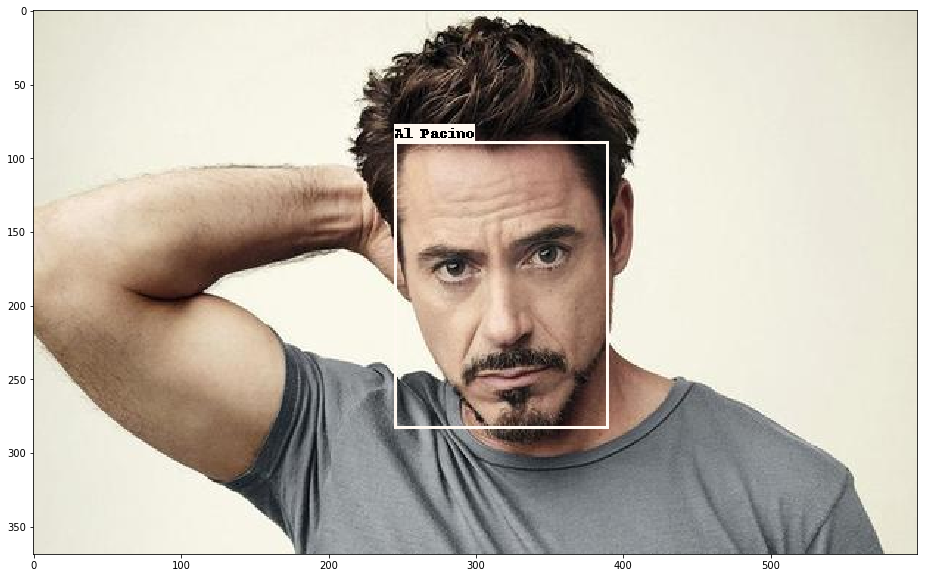

In [11]:
print('Start Recognition!')

face_input = "data/test/Robert_Downey.jpg"

find_results = []
frame = cv2.imread(face_input) # 讀入圖像
draw = frame.copy() # 複製原圖像


frame = frame[:,:,::-1] # 把BGR轉換成RGB
# 步驟 #1.偵測人臉位置
# 偵測人臉的邊界框
bounding_boxes, _ = detect_face.detect_face(frame, minsize, pnet, rnet, onet, threshold, factor)
nrof_faces = bounding_boxes.shape[0] # 被偵測到的臉部總數
if nrof_faces > 0: # 如果有偵測到人臉
    # 每一個 bounding_box包括了（x1,y1,x2,y2,confidence score)：
    # 　　左上角座標 (x1,y1)
    #     右下角座標 (x2,y2)
    #     信心分數 confidence score
    det = bounding_boxes[:, 0:4].astype(int) # 取出邊界框座標
    img_size = np.asarray(frame.shape)[0:2] # 原圖像大小 (height, width)
    
    print("Image: ", img_size)
    
    # 人臉圖像前處理的暫存
    cropped = []
    scaled = []
    scaled_reshape = []
    bb = np.zeros((nrof_faces,4), dtype=np.int32)
    
    # 步驟 #2.擷取人臉特徵
    for i in range(nrof_faces):
        print("faces#{}".format(i))
        emb_array = np.zeros((1, embedding_size))

        x1 = bb[i][0] = det[i][0]
        y1 = bb[i][1] = det[i][1]
        x2 = bb[i][2] = det[i][2]
        y2 = bb[i][3] = det[i][3]
        
        print('({}, {}) : ({}, {})'.format(x1,y1,x2,y2))
        # inner exception
        if bb[i][0] <= 0 or bb[i][1] <= 0 or bb[i][2] >= len(frame[0]) or bb[i][3] >= len(frame):
            print('face is out of range!')
            continue
        
        # **人臉圖像的前處理 **
            
        # 根據邊界框的座標來進行人臉的裁剪
        cropped.append(frame[bb[i][1]:bb[i][3], bb[i][0]:bb[i][2], :])
        cropped[i] = facenet.flip(cropped[i], False)
        scaled.append(misc.imresize(cropped[i], (image_size, image_size), interp='bilinear'))
        scaled[i] = cv2.resize(scaled[i], (input_image_size,input_image_size),
                               interpolation=cv2.INTER_CUBIC)
        scaled[i] = facenet.prewhiten(scaled[i])
        scaled_reshape.append(scaled[i].reshape(-1,input_image_size,input_image_size,3))       
        feed_dict = {images_placeholder: scaled_reshape[i], phase_train_placeholder: False}
        
        # 進行臉部特徵擷取
        emb_array[0, :] = tf_sess.run(embeddings, feed_dict=feed_dict)
        
        # 步驟 #3.進行人臉識別分類
        face_id_idx = face_svc_classifier.predict(emb_array)   
            
        if is_same_person(emb_array, int(face_id_idx), 1.1):            
            face_id_name = HumanNames[int(face_id_idx)] # 取出人臉的名字
            bb_color = vis_utils.STANDARD_COLORS[i] # 給予不同的顏色
            bb_fontcolor = 'black'
        else:
            face_id_name = 'Unknown'
            bb_color = 'BlueViolet' # 給予紅色
            bb_fontcolor = 'white'
        
        # 進行視覺化的展現
        vis_utils.draw_bounding_box_on_image_array(draw,y1,x1,y2,x2,
                                                   color=bb_color,
                                                   thickness=2,
                                                   display_str_list=[face_id_name],
                                                   fontname='calibrib.ttf',         # <-- 替換不同的字型
                                                   fontsize=25,                     # <-- 根據圖像大小設定字型大小
                                                   fontcolor=bb_fontcolor,
                                                   use_normalized_coordinates=False)
else:
    print('Unable to align')

print('Detected_FaceNum: %d' % nrof_faces)

# 設定展示的大小
plt.figure(figsize=(20,10))

# 展示偵測出來的結果
plt.imshow(draw[:,:,::-1]) # 轉換成RGB來給matplotlib展示
plt.show()